# 0.0. Understanding the problem

--Goal:
    
    --1.0 Predict the first destination that the new user will choose
    
    --Why?
        --What is the business model of Airbnb?
            --Marketplace (connect people who offer acomodation to whom are seeking a place)
            --Offer
                --Portfolio size
                --Portfolio diversity and density
                --Average price
                
            --Demand
                --Number of users
                --LTV (lifetime value)
                --CAC (client acquisition cost)
                
                Gross Revenue = (Fee*Number of clients) - CAC
                
--Solution:
    
    --Predictive model for the first destination of new user
    --1.0 Prediction save in a database
    --2.0 API
        --Input: User and features
        --Output: User and feature with destination prediction
        

# Module 1

## 0.0. Imports

### 0.1. Helper Functions

In [68]:
!pip install keras
!pip install tensorflow
!pip install scikit-plot

In [1]:
import pandas as pd
import random

from sklearn    import metrics         as m
from sklearn    import model_selection as ms
from sklearn    import preprocessing   as pp
from scikitplot import metrics         as mt

from keras import models as ml
from keras import layers as l

### 0.2. Loading Data

In [35]:
df_raw = pd.read_csv('dataset/train_users_2.csv', low_memory=True)
df_raw.shape

(213451, 16)

In [36]:
df_sessions = pd.read_csv('dataset/sessions.csv', low_memory=True)
df_sessions.shape

(10567737, 6)

# 1.0. Data Description

In [45]:
df1 = df_raw.copy()

## 1.1. Data Dimensions

In [46]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 213451
Number of columns: 16


In [39]:
print('Number of rows: {}'.format(df_sessions.shape[0]))
print('Number of columns: {}'.format(df_sessions.shape[1]))

Number of rows: 10567737
Number of columns: 6


## 1.2. Data Type

In [47]:
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [41]:
df_sessions.dtypes

user_id           object
action            object
action_type       object
action_detail     object
device_type       object
secs_elapsed     float64
dtype: object

## 1.3. NA Check

In [42]:
df1.isna().sum()/len(df1)

id                         0.000000
date_account_created       0.000000
timestamp_first_active     0.000000
date_first_booking         0.583473
gender                     0.000000
age                        0.412226
signup_method              0.000000
signup_flow                0.000000
language                   0.000000
affiliate_channel          0.000000
affiliate_provider         0.000000
first_affiliate_tracked    0.028414
signup_app                 0.000000
first_device_type          0.000000
first_browser              0.000000
country_destination        0.000000
dtype: float64

In [43]:
df_sessions.isna().sum()/len(df_sessions)

user_id          0.003264
action           0.007535
action_type      0.106570
action_detail    0.106570
device_type      0.000000
secs_elapsed     0.012872
dtype: float64

In [50]:
#remove missing data
#df1 = df1.dropna()

#date_first_booking
date_first_booking_max = pd.to_datetime(df1['date_first_booking']).max().strftime('%Y-%m-%d')
df1['date_first_booking'] = df1['date_first_booking'].fillna(date_first_booking_max)

#age
avg_age = df1['age'].mean()
df1['age'] = df1['age'].fillna(avg_age)

#first_affiliate_tracked
df1 = df1[~df1['first_affiliate_tracked'].isna()]

#user_id
df_sessions = df_sessions[~df_sessions['user_id'].isna()]

#action
df_sessions = df_sessions[~df_sessions['action'].isna()]

#action_type
df_sessions = df_sessions[~df_sessions['action_type'].isna()]

#action_detail
df_sessions = df_sessions[~df_sessions['action_detail'].isna()]

#secs_elapsed
df_sessions = df_sessions[~df_sessions['secs_elapsed'].isna()]

## 1.4. Change Data Type

In [9]:
#date_account_created
df1['date_account_created'] = pd.to_datetime(df1['date_account_created'])

#timestamp_first_active
df1['timestamp_first_active'] = pd.to_datetime(df1['timestamp_first_active'], format='%Y%m%d%H%M%S')

#date_first_booking
df1['date_first_booking'] = pd.to_datetime(df1['date_first_booking'])

#age
df1['age'] = df1['age'].astype(int)

## 1.5. Change Balanced Data

In [10]:
df1['country_destination'].value_counts(normalize=True)

US       0.708864
other    0.110854
FR       0.054085
IT       0.029763
GB       0.025935
ES       0.024864
CA       0.015696
DE       0.012454
NL       0.008801
AU       0.006366
PT       0.002318
Name: country_destination, dtype: float64

# 2.0. 

In [11]:
df2 = df1.copy()

## 2.1. Filtering Rows

## 2.2. Columns Selection

# 3.0. Data Preparation

In [12]:
df3 = df2.copy()

In [13]:
#dummy variable
df3_dummy = pd.get_dummies(df3.drop(['id','country_destination'], axis=1))

#join id and country destination
df3 = pd.concat([df3[['id','country_destination']], df3_dummy], axis=1)

# 4.0. Feature Seleciotn

In [14]:
cols_drop = ['date_account_created', 'timestamp_first_active', 'date_first_booking']
df4 = df3.drop(cols_drop, axis=1)

In [15]:
X = df4.drop(['id', 'country_destination'], axis=1)
y = df4['country_destination'].copy()

In [16]:
#split dataset into train and test
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=32)

# 5.0. Machine Learning

## 5.1. Baseline Model

In [19]:
country_destination_list = df1['country_destination'].drop_duplicates().sort_values().tolist()
k_num = y_test.shape[0]
country_destination_weights = df1['country_destination'].value_counts(normalize=True).sort_index().tolist()

yhat_random = random.choices(population=country_destination_list, 
                             weights=country_destination_weights,
                             k=k_num)
len(yhat_random)

13635

### 5.1.1. Baseline Performance

Accuracy: 0.5193986065273194
Balanced Accuracy: 0.09540021826929186
Kappa Accuracy: 0.0024676908107136297


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

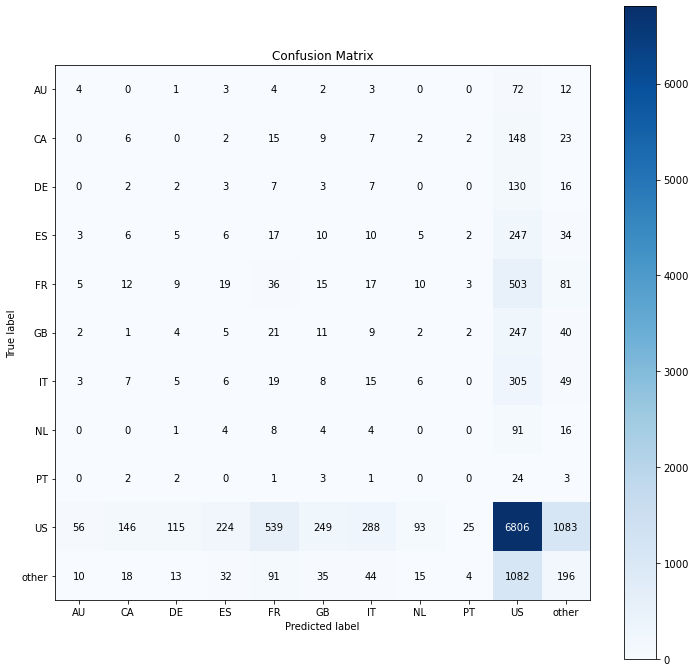

In [20]:
#accuracy
acc_random = m.accuracy_score(y_test, yhat_random)
print('Accuracy: {}'.format(acc_random))

#balanced accuracy
balanced_acc_random = m.balanced_accuracy_score(y_test, yhat_random)
print('Balanced Accuracy: {}'.format(balanced_acc_random))

#Kappa metrics
kappa_random = m.cohen_kappa_score(y_test, yhat_random)
print('Kappa Accuracy: {}'.format(kappa_random))

#confusion matrix
mt.plot_confusion_matrix(y_test, yhat_random, normalize=False, figsize=(12,12))

## 5.2. Neural Network - MLP

In [21]:
ohe = pp.OneHotEncoder()
y_train_nn = ohe.fit_transform(y_train.values.reshape(-1, 1)).toarray()

In [22]:
#model definition
model = ml.Sequential()
model.add(l.Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(l.Dense(11, activation='softmax'))

#model compile
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train_nn, epochs=10)

Epoch 1/10
1705/1705 [==============================] - 4s 1ms/step - loss: 1.3933 - accuracy: 0.6895
Epoch 2/10
1705/1705 [==============================] - 2s 1ms/step - loss: 1.2413 - accuracy: 0.7065
Epoch 3/10
1705/1705 [==============================] - 2s 1ms/step - loss: 1.2149 - accuracy: 0.7074
Epoch 4/10
1705/1705 [==============================] - 2s 1ms/step - loss: 1.2223 - accuracy: 0.7093
Epoch 5/10
1705/1705 [==============================] - 2s 1ms/step - loss: 1.1952 - accuracy: 0.7114
Epoch 6/10
1705/1705 [==============================] - 2s 1ms/step - loss: 1.1740 - accuracy: 0.7068
Epoch 7/10
1705/1705 [==============================] - 2s 1ms/step - loss: 1.1562 - accuracy: 0.7130
Epoch 8/10
1705/1705 [==============================] - 2s 1ms/step - loss: 1.1528 - accuracy: 0.7065
Epoch 9/10
1705/1705 [==============================] - 2s 1ms/step - loss: 1.1361 - accuracy: 0.7125
Epoch 10/10
1705/1705 [==============================] - 2s 1ms/step - loss: 1.149

### 5.2.1. NN Performance

In [23]:
#prediction
pred_nn = model.predict(X_test)

#invert prediction
yhat_nn = ohe.inverse_transform(pred_nn)

#prediction prepare
y_test_nn = y_test.to_numpy()
yhat_nn = yhat_nn.reshape(1, -1)[0]

Accuracy: 0.7058305830583058
Balanced Accuracy: 0.09090909090909091
Kappa Accuracy: 0.0


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

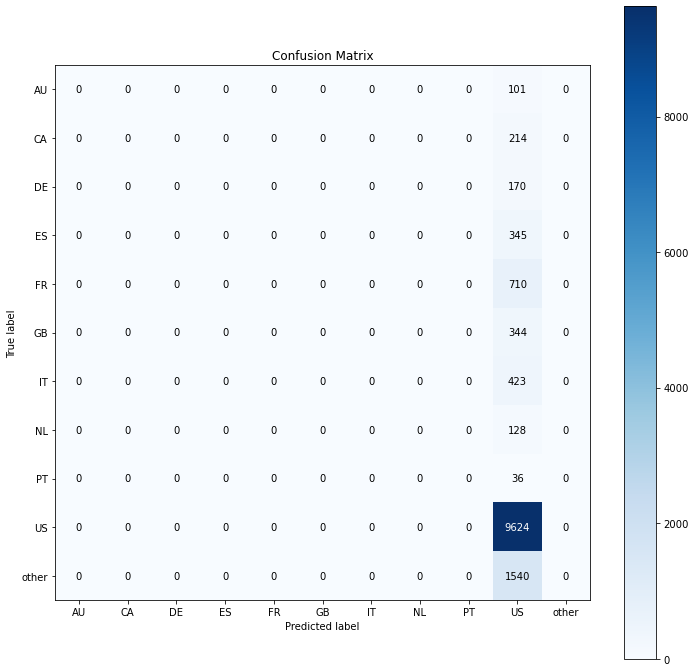

In [24]:
#accuracy
acc_nn = m.accuracy_score(y_test_nn, yhat_nn)
print('Accuracy: {}'.format(acc_nn))

#balanced accuracy
balanced_acc_nn = m.balanced_accuracy_score(y_test_nn, yhat_nn)
print('Balanced Accuracy: {}'.format(balanced_acc_nn))

#Kappa metrics
kappa_nn = m.cohen_kappa_score(y_test_nn, yhat_nn)
print('Kappa Accuracy: {}'.format(kappa_nn))

#confusion matrix
mt.plot_confusion_matrix(y_test_nn, yhat_nn, normalize=False, figsize=(12,12))

### 5.2.3. NN Performance - Cross-Validation

In [30]:
# generate k-fold
num_folds = 5
kfold = ms.StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=32)

balanced_acc_list = []
kappa_acc_list = []

i = 1

for train_ix, val_ix in kfold.split(X_train, y_train):
    print('Fold Number: {}/{}'.format(i, num_folds))
    
    #get fold
    x_train_fold = X_train.iloc[train_ix]
    y_train_fold = y_train.iloc[train_ix]
    
    x_val_fold = X_train.iloc[val_ix]
    y_val_fold = y_train.iloc[val_ix]
    
    #target hot-enconding
    ohe = pp.OneHotEncoder()
    y_train_fold_nn = ohe.fit_transform(y_train_fold.values.reshape(-1,1)).toarray()
    
    #model definition
    model = ml.Sequential()
    model.add(l.Dense(256, input_dim=X_train.shape[1], activation='relu'))
    model.add(l.Dense(11, activation='softmax'))
    
    #compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    #training model
    model.fit(x_train_fold, y_train_fold_nn, epochs=100, batch_size=32, verbose=0)
    
    #prediction
    pred_nn = model.predict(x_val_fold)
    yhat_nn = ohe.inverse_transform(pred_nn)
    
    #prepare data
    y_test_nn = y_val_fold.to_numpy()
    yhat_nn = yhat_nn.reshape(1, -1)[0]
    
    #metrics
    ##Balanced Accuracy
    baanced_acc_nn = m.balanced_accuracy_score(y_test_nn, yhat_nn)
    balanced_acc_list.append(balanced_acc_nn)
    
    ##Kappa Metrics
    kappa_acc_nn = m.cohen_kappa_score(y_test_nn, yhat_nn)
    kappa_acc_list.append(kappa_acc_nn)
    
    i+=1

Fold Number: 1/5
Fold Number: 2/5
Fold Number: 3/5
Fold Number: 4/5
Fold Number: 5/5
